In [1]:
import json
import os
import sys

import matplotlib.pyplot as plt
import numpy as np
from tensorflow import keras

from shapely.geometry import box
from geojson import Point, Feature, FeatureCollection, dump
import geopandas

sys.path.append('../')
from scripts.get_s2_data_ee import get_history, get_history_polygon, get_pixel_vectors

%load_ext autoreload
%autoreload 2

In [20]:
# Sentinel 2 band descriptions
band_descriptions = {
    'B1': 'Aerosols, 442nm',
    'B2': 'Blue, 492nm',
    'B3': 'Green, 559nm',
    'B4': 'Red, 665nm',
    'B5': 'Red Edge 1, 704nm',
    'B6': 'Red Edge 2, 739nm',
    'B7': 'Red Edge 3, 779nm',
    'B8': 'NIR, 833nm',
    'B8A': 'Red Edge 4, 864nm',
    'B9': 'Water Vapor, 943nm',
    'B11': 'SWIR 1, 1610nm',
    'B12': 'SWIR 2, 2186nm'
}

def create_img_stack(patch_history):
    img_stack = []
    for date in patch_history:
        for site in patch_history[date]:
            spectral_stack = []
            band_shapes = [np.shape(patch_history[date][site][band])[0] for band in band_descriptions]
            if np.array(band_shapes).all() > 0:
                for band in band_descriptions:
                    spectral_stack.append(patch_history[date][site][band])
                if np.median(spectral_stack) > 0:
                    img_stack.append(np.rollaxis(np.array(spectral_stack), 0, 3))
    return img_stack

def get_image_stack(coords, start_date='2020-05-01', rect_width=0.025, scale=10, num_months=1):
    names = ['sample_' + str(i) for i in range(len(coords))]
    history = get_history(coords, 
                          names,
                          rect_width,
                          start_date=start_date,
                          num_months=num_months,
                          #scale=rect_width * (100 / 0.025)
                          scale=scale
                         )
    img_stack = create_img_stack(history)
    print("Image shape before cropping:", img_stack[0].shape)
    min_dim = np.min([img.shape[:2] for img in img_stack])
    img_stack = [img[:min_dim, :min_dim, :] for img in img_stack]
    
    return history, img_stack

def create_img_stack_mean(patch_history):
    mean_stack = []
    dates = list(patch_history.keys())
    for site in patch_history[dates[0]]:
        img_stack = []
        for date in dates:
            spectral_stack = []
            band_shapes = [np.shape(patch_history[date][site][band])[0] for band in band_descriptions]
            if np.array(band_shapes).all() > 0:
                for band in band_descriptions:
                    spectral_stack.append(patch_history[date][site][band])
                img_stack.append(np.rollaxis(np.array(spectral_stack), 0, 3))

        masked_img = []
        for img in img_stack:
            masked_img.append(np.ma.masked_where(img < 0, img))
        
        masked_mean = np.ma.mean(masked_img, axis=0)
        
        num_cloudy_pixels = np.sum(masked_mean.mask)
        cloud_fraction = num_cloudy_pixels / np.size(masked_mean)
        
        print("Cloud Fraction", cloud_fraction)
        if cloud_fraction < 0.2:
            mean_stack.append(masked_mean.data)
    return mean_stack

def stretch_histogram(array, min_val=0.1, max_val=0.75, gamma=1.2):
    clipped = np.clip(array, min_val, max_val)
    stretched = np.clip((clipped - min_val) / (max_val - min_val) ** gamma, 0, 1)
    return stretched

def create_rgb(img_array):
    rgb_img = []
    for img in img_array:
        rgb = np.stack((img[:,:,3],
                        img[:,:,2],
                        img[:,:,1]), axis=-1)
        rgb = stretch_histogram(normalize(rgb), 0.1, 1)
        rgb_img.append(rgb)
    return rgb_img

def normalize(x):
    return (np.array(x)) / (3000)

In [41]:
rect_width = 0.0075
scale = 10
num_months = 4

In [42]:
patch_coords = [
                    [[-63.584846, 6.3755895], [-63.5848374, 6.3679911], [-63.5772424, 6.3679997], [-63.5772509, 6.3755981]],
                    [[-63.5848546, 6.3831879], [-63.584846, 6.3755895], [-63.5772509, 6.3755981], [-63.5772594, 6.3831965]],
                    [[-63.5772509, 6.3755981], [-63.5772424, 6.3679997], [-63.5696473, 6.3680081], [-63.5696557, 6.3756065]],
                    [[-63.5772594, 6.3831965], [-63.5772509, 6.3755981], [-63.5696557, 6.3756065], [-63.5696641, 6.383205]]
               ]

In [43]:
model = keras.models.load_model('../models/84_px_inception_v4_02-08-21.h5')

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:05<00:15,  5.29s/it]

 50%|█████     | 2/4 [00:07<00:08,  4.29s/it]

 75%|███████▌  | 3/4 [00:09<00:03,  3.56s/it]

100%|██████████| 4/4 [00:10<00:00,  2.74s/it]


Image shape before cropping: (85, 84, 12)
Cloud Fraction 0.0


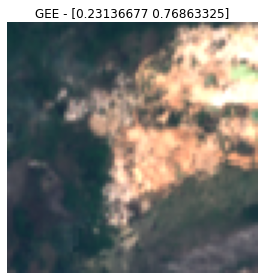

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:01<00:05,  1.83s/it]

 50%|█████     | 2/4 [00:03<00:03,  1.80s/it]

 75%|███████▌  | 3/4 [00:05<00:01,  1.79s/it]

100%|██████████| 4/4 [00:06<00:00,  1.73s/it]


Image shape before cropping: (84, 84, 12)
Cloud Fraction 0.0


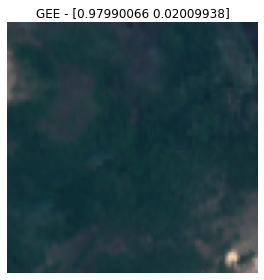

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:01<00:04,  1.65s/it]

 50%|█████     | 2/4 [00:03<00:03,  1.77s/it]

 75%|███████▌  | 3/4 [00:12<00:03,  3.92s/it]

100%|██████████| 4/4 [00:16<00:00,  4.00s/it]


Image shape before cropping: (85, 85, 12)
Cloud Fraction 0.0


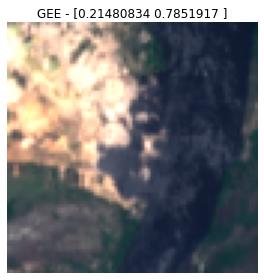

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:03<00:11,  3.81s/it]

 50%|█████     | 2/4 [00:05<00:06,  3.19s/it]

 75%|███████▌  | 3/4 [00:07<00:02,  2.79s/it]

100%|██████████| 4/4 [00:09<00:00,  2.27s/it]


Image shape before cropping: (84, 85, 12)
Cloud Fraction 0.0


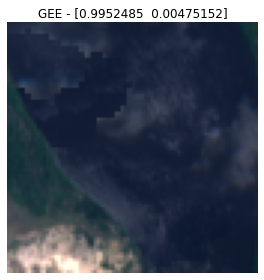

In [47]:
for coords in patch_coords:
    lon = [coord[0] for coord in coords]
    lat = [coord[1] for coord in coords]
    history, img_stack = get_image_stack([[np.mean(lon), np.mean(lat)]], rect_width=rect_width, scale=scale, num_months=num_months)
    mean_stack = create_img_stack_mean(history)
    test_data = [img[:84, :84, :] for img in mean_stack]
    rgb = create_rgb(test_data)
    plt.imshow(rgb[0])
    plt.axis('off')
    plt.title(f"GEE - {model.predict(normalize(test_data))[0]}")
    plt.tight_layout()
    plt.savefig(f"{lon}_{lat}.png")
    plt.show()

In [22]:
coords = [[-63.584846, 6.3755895], [-63.5848374, 6.3679911], [-63.5772424, 6.3679997], [-63.5772509, 6.3755981]]
lon = [coord[0] for coord in coords]
lat = [coord[1] for coord in coords]

In [23]:
history, img_stack = get_image_stack([[np.mean(lon), np.mean(lat)]], rect_width=rect_width, scale=scale, num_months=num_months)

  0%|          | 0/4 [00:00<?, ?it/s]

 25%|██▌       | 1/4 [00:02<00:06,  2.28s/it]

 50%|█████     | 2/4 [00:06<00:05,  2.96s/it]

 75%|███████▌  | 3/4 [00:08<00:02,  2.65s/it]

100%|██████████| 4/4 [00:10<00:00,  2.70s/it]

Image shape before cropping: (85, 86, 12)


In [29]:
mean_stack = create_img_stack_mean(history)
test_data = [img[:84, :84, :] for img in mean_stack]

Cloud Fraction 0.0


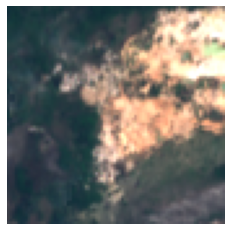

In [31]:
rgb = create_rgb(test_data)
plt.imshow(rgb[0])
plt.axis('off')
plt.show()

In [35]:
model.predict(normalize(test_data))

array([[0.23411618, 0.76588386]], dtype=float32)